In [ ]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
#load fields
bars = pd.read_csv('barcodes.csv')
bar = []

In [4]:
print(bars.columns)

Index(['code', 'field', 'link'], dtype='object')


In [5]:
for _, row in bars.iterrows():
    #Do the same for barcode as we did for collaborations 
    link = row['link'].strip().strip('"').strip("'")
    df = pd.read_pickle(link)
    df['field'] = row['field']
    df['code'] = row['code']
    bar.append(df)


#Merge all the individual field barcodes into one dataframe 
new = pd.concat(bar, ignore_index=True)

new

,dimension,birth,death,birth simplex,death simplex,field,code
0,0,0.970297,0.980198,[3626],"[493, 3626]",Accounting_Auditing_Accountability,1501
1,0,0.970297,0.980198,[2220],"[1714, 2220]",Accounting_Auditing_Accountability,1501
2,0,0.970297,0.980198,[170],"[112, 170]",Accounting_Auditing_Accountability,1501
3,0,0.960396,0.980198,[4010],"[216, 4010]",Accounting_Auditing_Accountability,1501
4,0,0.960396,0.980198,[3837],"[1874, 3837]",Accounting_Auditing_Accountability,1501
...,...,...,...,...,...,...,...
6831540,3,0.960396,1.000000,"[1051, 1222, 1243, 1555]","[614, 1051, 1222, 1555, 2019]",Zoology,608
6831541,3,0.960396,inf,"[437, 447, 1174, 1243]",None,Zoology,608
6831542,3,0.960396,0.990099,"[437, 447, 1174, 1222]","[1025, 1066, 1174, 1558, 1730]",Zoology,608
6831543,3,0.960396,0.990099,"[271, 273, 666, 1051]","[273, 279, 666, 871, 1051]",Zoology,608


In [8]:
birth_min = new['birth'].replace(np.inf, np.nan).min()
birth_max = new['birth'].replace(np.inf, np.nan).max()

death_min = new['death'].replace(np.inf, np.nan).min()
death_max = new['death'].replace(np.inf, np.nan).max()

print(f"birth range: {birth_min:.3f} to {birth_max:.3f}")
print(f"death range: {death_min:.3f} to {death_max:.3f}")

birth range: 0.000 to 1.000
death range: 0.020 to 1.000


In [9]:
#set filtration
birth_vals = np.linspace(0.0, 1.0, 97)
death_vals = np.linspace(0.0, 1.0, 37)
max_dim = 1
betti_all = {}

for field, df_field in new.groupby("field"):
    betti = np.zeros((len(birth_vals), len(death_vals), max_dim + 1))

    for dim in range(max_dim + 1):
        df_dim = df_field[df_field['dimension'] == dim]

        for _, row in df_dim.iterrows():
            birth = row['birth']
            death = row['death']

            if np.isinf(death):
                continue

            birth_idx = np.searchsorted(birth_vals, birth, side='right') - 1
            death_idx = np.searchsorted(death_vals, death, side='left')

            if birth_idx < 0 or birth_idx >= len(birth_vals):
                continue
            if death_idx < 0 or death_idx > len(death_vals):
                continue

            #betti matrix
            for i in range(birth_idx, len(birth_vals)):
                for j in range(death_idx):
                    betti[i, j, dim] += 1

    betti_all[field] = betti

print(len(betti_all))


133


In [10]:
# vectorize
X_vecs = []
fields_vec = []
for field, bc in betti_all.items():
    vec = bc.flatten()
    X_vecs.append(vec)
    fields_vec.append(field)

X = np.array(X_vecs)

print(f"Vectorized shape: {X.shape}")

Vectorized shape: (133, 7178)


In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=50, random_state=1)
X_reduced = pca.fit_transform(X)

In [19]:
#k-mean
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

cluster_df = pd.DataFrame({
    'field': fields_vec,
    'cluster': labels
})
print(cluster_df.head())
display(cluster_df.sort_values(by='cluster'))

                                 field  cluster
0                 AI_Image_Processing         4
1  Accounting_Auditing_Accountability         0
2                Aerospace_Engineering        3
3          Agricultural_Biotechnology         3
4    Agriculture_Land_Farm_Management         3


,field,cluster
65,Human_Geography,0
91,Neurosciences,0
96,Oncology_Carcinogenesis,0
33,Computation_Theory_Mathematics,0
99,Organic_Chemistry,0
...,...,...
77,Literary_Studies,7
24,Chemical_Engineering,7
47,Ecological_Applications,7
39,Cultural_Studies,7


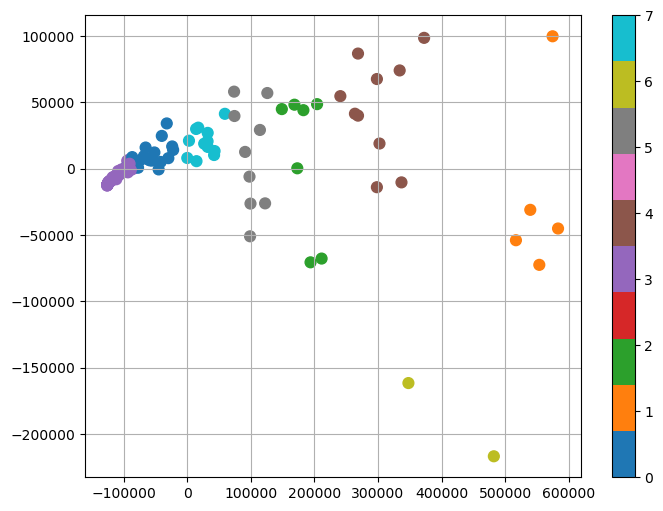

In [22]:
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=60)
plt.colorbar(scatter)
plt.grid(True)
plt.show()

In [24]:
#group 0
cluster_0_fields = cluster_df[cluster_df['cluster'] == 0]['field'].to_list()
print(len(cluster_0_fields))
print(cluster_0_fields)


19
['Accounting_Auditing_Accountability ', 'Cardiorespiratory_Medicine_Haematology ', 'Clinical_Sciences ', 'Cognitive_Sciences ', 'Computation_Theory_Mathematics ', 'Data_Format ', 'Economic_Theory ', 'Electrical_Electronic_Engineering ', 'Environmental_Engineering ', 'Evolutionary_Biology ', 'Human_Geography ', 'Mechanical_Engineering ', 'Neurosciences ', 'Oncology_Carcinogenesis ', 'Organic_Chemistry ', 'Other_Biological_Sciences ', 'Public_Health_Health_Services ', 'Quantum_Physics ', 'Resource_Engineering_Extractive_Metallurgy ']


In [ ]:
def drawcrocker(field):
    bc = betti_all[field]
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for dim, ax in enumerate(axs):
        Z = bc[:, :, dim].T
        Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)

        cp = ax.contour(
            X, Y, Z,
            levels=[1, 5, 10, 20, 50, 100, 200, 300, 500, 800, 1300, 2000, 3000],
            colors='black', linewidths=0.8
        )
        if cp.collections:
            ax.clabel(cp, inline=True, fontsize=8)

        ax.set_xlabel("Normalized Year")
        ax.set_title(f"{field}  —  $\\beta_{dim}$")

    axs[0].set_ylabel("Inv_count")
    plt.tight_layout()
    plt.show()

In [2]:
#crocker
X, Y = np.meshgrid(birth_vals, death_vals)

for field in cluster_0_fields:
    drawcrocker(field)

NameError: name 'np' is not defined

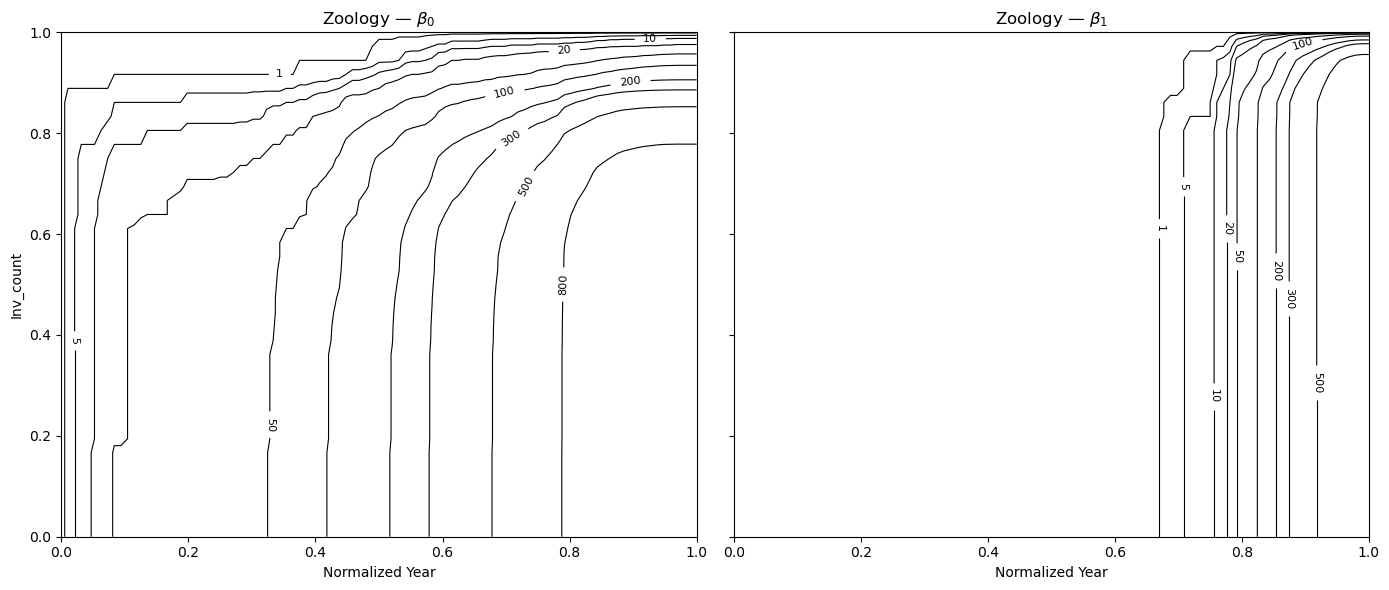

In [30]:
X, Y = np.meshgrid(birth_vals, death_vals)

# 提取 zoology 对应的 betti_curves
zoology_bc = betti_all['Zoology ']

# 画图
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for dim, ax in enumerate(axs):
    Z = zoology_bc[:, :, dim].T
    Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)

    cp = ax.contour(
        X, Y, Z,
        levels=[1, 5, 10, 20, 50, 100, 200, 300, 500, 800, 1300, 2000, 3000],
        colors='black', linewidths=0.8
    )
    if cp.collections:
        ax.clabel(cp, inline=True, fontsize=8)

    ax.set_xlabel("Normalized Year")
    ax.set_title(f"Zoology — $\\beta_{dim}$")

axs[0].set_ylabel("Inv_count")
plt.tight_layout()
plt.show()

In [29]:
print(sorted(betti_all.keys()))

['AI_Image_Processing ', 'Accounting_Auditing_Accountability ', 'Aerospace_Engineering', 'Agricultural_Biotechnology ', 'Agriculture_Land_Farm_Management ', 'Analytical_Chemistry ', 'Animal_Production ', 'Anthropology ', 'Applied_Economics ', 'Applied_Ethics ', 'Applied_Mathematics ', 'Archaeology ', 'Architecture ', 'Art_Theory_Criticism ', 'Astronomical_Space_Sciences ', 'Atmospheric_Sciences ', 'Atomic_Molecular_Nuclear_Particle_Plasma_Physics ', 'Automotive_Engineering ', 'Banking_Finance_Investing ', 'Biochemistry_Cell_Biology ', 'Biomedical_Engineering ', 'Building ', 'Business_Management ', 'Cardiorespiratory_Medicine_Haematology ', 'Chemical_Engineering ', 'Civil_Engineering ', 'Classical_Physics ', 'Clinical_Sciences ', 'Cognitive_Sciences ', 'Commercial_Servies ', 'Communication_Media_Studies ', 'Communication_Technologies ', 'Complementary_Alternative_Medicine ', 'Computation_Theory_Mathematics ', 'Computer_Hardware ', 'Computer_Software  ', 'Condensed_Matter_Physics ', 'Cri